In [1]:
import sys
import pandas as pd
import numpy as np
import hdbscan
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from scipy.spatial.distance import cdist


In [2]:
def load_data(path):
    df = pd.read_csv(path)
    df.drop(columns=['id'], inplace=True)
    data = df.to_numpy()
    return data
def save_results(clusters, path):
    assert path.endswith('.csv'), "Output path must be a CSV file"
    with open(path, 'w') as f:
        f.write('id,label\n')
        for i, cluster in enumerate(clusters):
            f.write(f'{i}, {cluster}\n')
input_path = 'public_data.csv'
input_path_private = 'private_data.csv'
public_data = load_data(input_path)
private_data = load_data(input_path_private)
n_dimensions = public_data.shape[1]

In [3]:
def eval(path):
    import pandas as pd
    from grader import score

    submission = pd.read_csv(path).sort_values("id").reset_index(drop=True)
    labels_pred = submission["label"].tolist()

    print(f"Score: {score(labels_pred):.4f}")


In [4]:
def apply_pca(data, n_components=2):
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(data)
    return reduced_data


In [28]:
def process_data(data):
    data = apply_pca(data, n_components=4)
    # data = np.concat([apply_pca(data, n_components=3), apply_pca(data, n_components=4)], axis=1) 
    scaler = RobustScaler()
    data = scaler.fit_transform(data)
    return data

In [6]:
def visualize_clusters(data, clusters=None):
    # Reduce to 2D
    if clusters is None:
        clusters = np.zeros(data.shape[0])  # Default to a single cluster if none provided
    data = process_data(data)
    fig = plt.figure(figsize=(8, 6))
    if data.shape[1] == 2:
        scatter = plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='tab20', s=2)
        plt.title('2D PCA Projection')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    elif data.shape[1] == 3:
        ax = plt.axes(projection='3d')
        scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=clusters, cmap='tab20', s=2)
        ax.set_title('3D PCA Projection')
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
    else:
        print(data.shape, "Not 2D or 3D, skipping visualization")
        return
    fig.colorbar(scatter, label='Cluster')
    plt.show()

In [7]:

# def cluster_data(data, method="gmm", n_clusters=None):
#     # Preprocessing
#     processed_data = process_data(data)

#     if method == "kmeans":
#         model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
#         clusters = model.fit_predict(processed_data)
#     elif method == "gmm":
#         model = GaussianMixture(n_components=n_clusters, random_state=42, n_init=5)
#         clusters = model.fit_predict(processed_data)
#     elif method == "hdbscan":
#         model = hdbscan.HDBSCAN(min_cluster_size=10)
#         clusters = model.fit_predict(processed_data)
#     else:
#         raise ValueError("Unsupported clustering method")

#     return clusters, model

def cluster_data(data, method="gmm"):
    n_clusters = 4 * data.shape[1] - 1
    # Step 1: Preprocess the data
    processed_data = process_data(data)

    # Step 2: Detect inliers using Isolation Forest
    iso_forest = IsolationForest(contamination=0.00001, random_state=42)
    is_inlier = iso_forest.fit_predict(processed_data) == 1
    inliers = processed_data[is_inlier]
    outliers = processed_data[~is_inlier]
    print(f"Ratio of inliers: {inliers.shape[0]}/{processed_data.shape[0]} = {inliers.shape[0] / processed_data.shape[0]:.2f}")

    # Step 3: Cluster only inliers
    if method == "kmeans":
        model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        inlier_labels = model.fit_predict(inliers)

        # Step 4: Assign outliers to nearest centroid
        centroids = model.cluster_centers_
        distances = cdist(outliers, centroids)
        outlier_labels = np.argmin(distances, axis=1)

    elif method == "gmm":
        model = GaussianMixture(n_components=n_clusters, random_state=42, n_init=5)
        inlier_labels = model.fit_predict(inliers)

        # Step 4: Assign outliers to most probable component
        outlier_labels = model.predict(outliers)

    elif method == "hdbscan":
        model = hdbscan.HDBSCAN(min_cluster_size=10)
        inlier_labels = model.fit_predict(inliers)

        # Step 4: Assign outliers to nearest cluster centroid (computed manually)
        unique_labels = np.unique(inlier_labels[inlier_labels != -1])
        centroids = np.array([inliers[inlier_labels == lbl].mean(axis=0) for lbl in unique_labels])
        distances = cdist(outliers, centroids)
        nearest_cluster = np.argmin(distances, axis=1)
        outlier_labels = unique_labels[nearest_cluster]

    else:
        raise ValueError("Unsupported clustering method")

    # Step 5: Combine labels into full result
    full_labels = np.empty(len(processed_data), dtype=int)
    full_labels[is_inlier] = inlier_labels
    full_labels[~is_inlier] = outlier_labels

    return full_labels, model
def cluster_data_hybrid(data):
    n_clusters = 4 * data.shape[1] - 1
    # Preprocessing
    processed_data = process_data(data)
    
    # Initialize models
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    gmm_model = GaussianMixture(n_components=n_clusters, random_state=42, n_init=5)
    hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=10)
    
    # Get predictions from each model
    kmeans_clusters = kmeans_model.fit_predict(processed_data)
    gmm_clusters = gmm_model.fit_predict(processed_data)
    hdbscan_clusters = hdbscan_model.fit_predict(processed_data)
    
    # Start with KMeans as the base
    final_clusters = kmeans_clusters.copy()
    
    # For points where GMM and HDBSCAN agree (and HDBSCAN is not noise), use their label
    for i in range(processed_data.shape[0]):
        if hdbscan_clusters[i] != -1 and gmm_clusters[i] == hdbscan_clusters[i]:
            final_clusters[i] = gmm_clusters[i]
        elif hdbscan_clusters[i] == -1:
            # Mark as noise if HDBSCAN says so
            final_clusters[i] = -1

    return final_clusters, None

In [ ]:
def partial_cluster_data(data, n_init_clusters=5):
    # Cluster data into 5 classes for each feature pair, then combine into final clusters
    n_clusters = 4 * data.shape[1] - 1
    # Step 1: Cluster on each feature pair
    pair_indices = [(i, i + 1) for i in range(data.shape[1] - 1)]
    pair_labels = []
    scaler = RobustScaler()
    data = scaler.fit_transform(data)

    for idx1, idx2 in pair_indices:
        pair_data = data[:, [idx1, idx2]]
        kmeans = KMeans(n_clusters=n_init_clusters, random_state=42, n_init=1)
        labels = kmeans.fit_predict(pair_data)
        pair_labels.append(labels)

    pair_labels = np.stack(pair_labels, axis=1) 

    # Step 2: Combine the three clusterings into a single label
    final_labels = sum(pair_labels[:, i] * (n_init_clusters ** i) for i in range(pair_labels.shape[1]))

    # Step 3: Map combined labels to 15 clusters (4*4-1=15)
    # Use KMeans on the combined encoding to reduce to 15 clusters
    unique_encodings = np.unique(final_labels)
    encoding_to_index = {enc: i for i, enc in enumerate(unique_encodings)}
    encoded_features = np.array([encoding_to_index[enc] for enc in final_labels]).reshape(-1, 1)
    advanced_features = np.array([
        np.mean(data, axis=1),
        np.std(data, axis=1),
    ]).T
    # data = np.concatenate([data, advanced_features], axis=1)
    data = np.concatenate([data, encoded_features], axis=1)  # Add encoded features to data

    # data = process_data(data)
    kmeans_final = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    final_clusters = kmeans_final.fit_predict(data)

    return final_clusters, kmeans_final

In [88]:
method = 'partial'
output_path = f'public_submission.csv'
if method in ["kmeans", "gmm", "hdbscan"]:
    public_clusters, _ = cluster_data(public_data, method=method)
elif method == "hybrid":
    public_clusters, _ = cluster_data_hybrid(public_data)
elif method == "partial":
    public_clusters, _ = partial_cluster_data(public_data, 5)
save_results(public_clusters, output_path)
eval(output_path)

Score: 0.8890


In [89]:
method = 'partial'
output_path_private = f'private_submission.csv'
if method in ["kmeans", "gmm", "hdbscan"]:
    private_clusters, _ = cluster_data(private_data, method=method)
elif method == "hybrid":
    private_clusters, _ = cluster_data_hybrid(private_data)
elif method == "partial":
    private_clusters, _ = partial_cluster_data(private_data, 5)
save_results(private_clusters, output_path_private)

In [ ]:
# visualize_clusters(public_data)
clusters = None
visualize_clusters(public_data, public_clusters)
visualize_clusters(private_data, private_clusters)

(49771, 7) Not 2D or 3D, skipping visualization
(200000, 7) Not 2D or 3D, skipping visualization


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [77]:
def visualize_features(data, f1, f2=None, f3=None, clusters=None):
    # data = process_data(data)
    if f3 is not None:
        fig = plt.figure(figsize=(4, 3))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(data[:, f1], data[:, f2], data[:, f3], s=2)
        ax.set_title(f'Feature {f1}, {f2}, {f3}')
        ax.set_xlabel(f'Feature {f1}')
        ax.set_ylabel(f'Feature {f2}')
        ax.set_zlabel(f'Feature {f3}')
        plt.show()
    elif f2 is not None:
        plt.figure(figsize=(4, 3))
        plt.scatter(data[:, f1], data[:, f2], s=2, c=clusters, cmap='tab20' if clusters is not None else 'viridis')
        plt.title(f'Feature {f1} vs Feature {f2}')
        plt.xlabel(f'Feature {f1}')
        plt.ylabel(f'Feature {f2}')
        plt.show()
    elif f1 is not None:
        plt.figure(figsize=(4, 3))
        plt.scatter(data[:, f1], np.zeros_like(data[:, f1]), s=10, c=clusters, cmap='tab20' if clusters is not None else 'viridis')
        plt.title(f'Feature {f1} Distribution')
        plt.xlabel(f'Feature {f1}')
        plt.ylabel('Frequency')
        plt.show()
    
def visualize_all_features(data, preprocess=True, clusters=None):
    if preprocess:
        data = process_data(data)
    n_features = data.shape[1]
    for i in range(n_features):
        visualize_features(data, i, clusters=clusters)
        for j in range(i + 1, n_features):
            visualize_features(data, i, j, clusters=clusters)

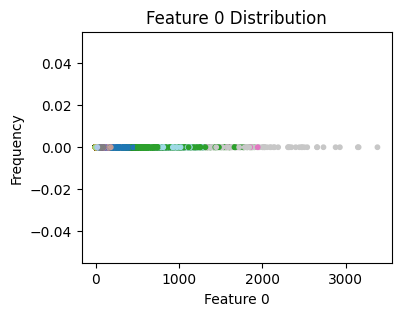

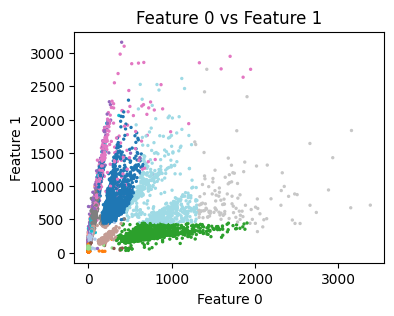

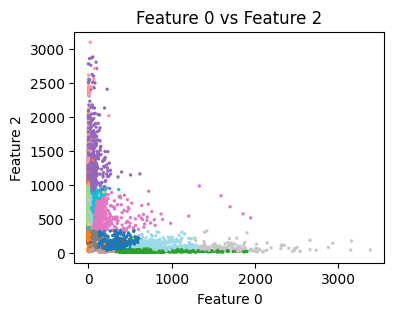

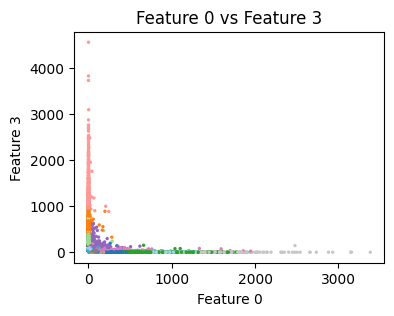

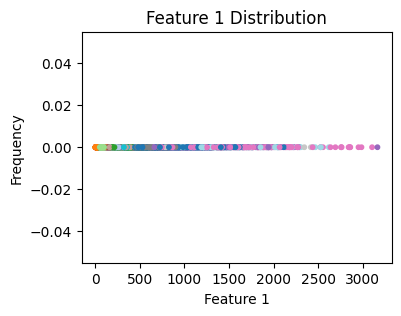

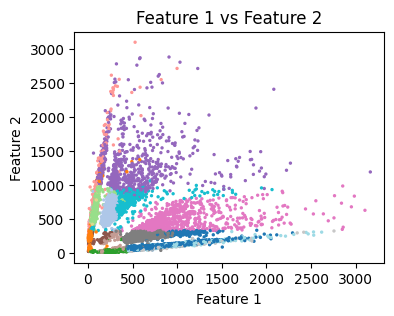

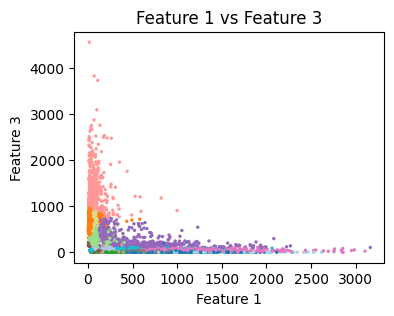

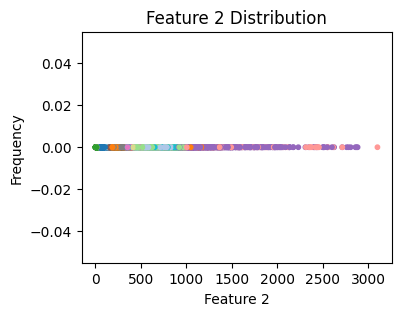

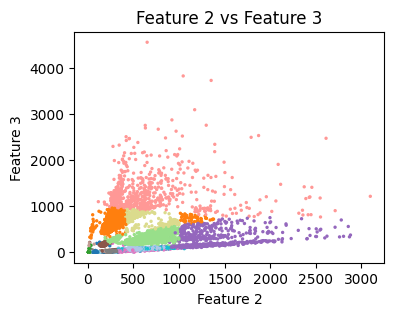

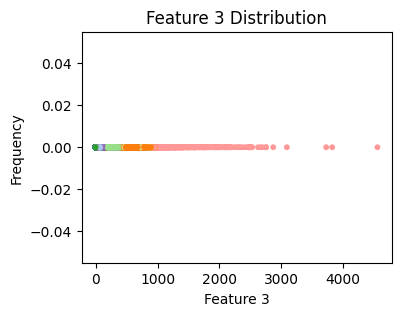

In [78]:
visualize_all_features(public_data, preprocess=False, clusters=public_clusters)

/tmp/ipykernel_4162026/3920265973.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data[:, f1], data[:, f2], s=2, c=clusters, cmap='tab20' if clusters is not None else 'viridis')


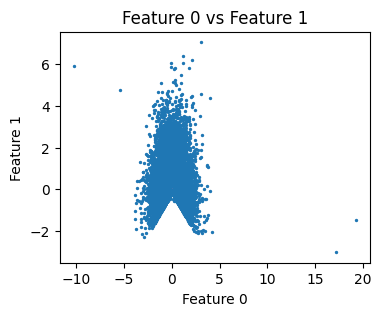

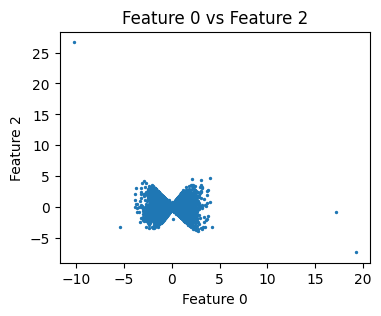

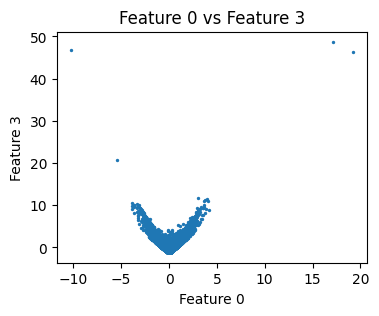

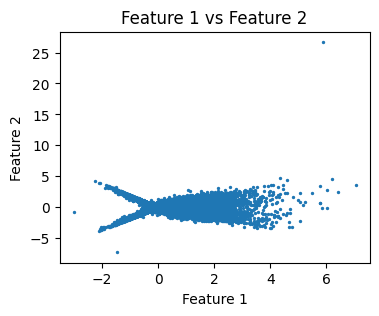

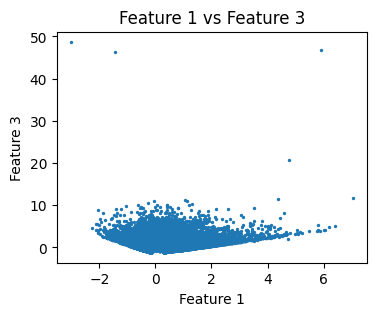

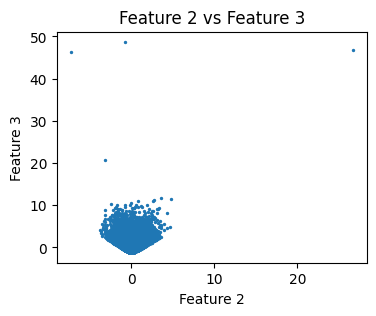

In [73]:
visualize_all_features(private_data)